# Working with the 6-hourly Global Drifter Program (GDP) data

In this Notebook, we use the [6-hourly data](https://www.aoml.noaa.gov/phod/gdp/interpolated/data/all.php) from the [NOAA Global Drifter Program](https://www.aoml.noaa.gov/global-drifter-program/) to illustrate the steps necessary to process a Lagrangian dataset into a `RaggedArray` class object. This object can subsequently be converted to `xarray.Dataset` or `awkward.Array` instances for analysis. We also show how the *RaggedArray* object can also be written into files for archival.

## Import the `RaggedArray` class

In [1]:
from clouddrift import RaggedArray

## Dataset-specific functions

The `gdp6h.py` module (inside `clouddrift.adapters`) contains a number of specific functions for the current GDP 6-hourly files, including:

- `gdp6h.preprocess`: Preprocess and return an `xarray.Dataset` for a specific trajectory. 
- `gdp6h.download`: Download NetCDF files from the GDP FTP server.
- `gdp6h.rowsize [Optional]`: Return the dimension of a specific trajectory to speed up the preprocessing.

In [2]:
from clouddrift.adapters import gdp6h

## Download the GDP data

The `gdp6h.download` function will store the raw dataset into the `data/raw/gdp-6hourly/` folder (specified in the `gdp6h.py` module). By default `download()` will download the GPD dataset available on the [FTP/HTTPS repository](https://www.aoml.noaa.gov/ftp/pub/phod/lumpkin/netcdf/)).

In [3]:
help(gdp6h.download)

Help on function download in module clouddrift.adapters.gdp6h:

download(url: str = 'https://www.aoml.noaa.gov/ftp/pub/phod/buoydata/6h', tmp_path: str = '/var/folders/_6/hdhmyzr120jgn1d_45q65zkh0000gn/T/clouddrift/gdp6h', drifter_ids: list[int] | None = None, n_random_id: int | None = None)
    Download individual NetCDF files from the AOML server.

    Parameters
    ----------
    url : str
        URL from which to download the data (Default: GDP_DATA_URL). Alternatively, it can be GDP_DATA_URL_EXPERIMENTAL.
    tmp_path : str, optional
        Path to the directory where the individual NetCDF files are stored
        (default varies depending on operating system; /tmp/clouddrift/gdp6h on Linux)
    drifter_ids : list
        List of drifter to retrieve (Default: all)
    n_random_id : int
        Randomly select n_random_id drifter IDs to download (Default: None)


    Returns
    -------
    out : list
        List of retrieved drifters



With this function, it is also possible to retrieve a subset from a `drifter_ids` list or specified an integer `n_random_id` to randomly retrieve `n` trajectory. If both arguments are given, the function downloads `n_random_id` out of the list `drifter_ids`. The function returns the list of `drifters_ids` that was downloaded, and can be passed to create the ragged array.

In [4]:
drifter_ids = gdp6h.download(n_random_id=100)

In [5]:
drifter_ids[:5]

array([7711162, 7720050, 9422271, 9525467, 9320963])

## Create the `RaggedArray` instance

Once the data are downloaded, the *RaggedArray* object can be created and archived as a NetCDF file or a parquet file. In addition, the ragged array can be converted to an [xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) or an [Awkward Array](https://awkward-array.readthedocs.io/en/stable/_auto/ak.Array.html) in order to conduct analyses.

Before we do that, we must first define the dataset-specific coordinates, data, and metadata information.

In [7]:
dimensions = {"traj": "rows", "obs": "obs"}

coords = [
    "id",
    "time",
]
data = [
    "lon",
    "lon360",
    "lat",
    "ve",
    "vn",
    "temp",
    "err_lat",
    "err_lon",
    "err_temp",
    "drogue_status",
]
metadata = [
    "rowsize",
    "WMO",
    "expno",
    "deploy_date",
    "deploy_lat",
    "deploy_lon",
    "end_date",
    "end_lat",
    "end_lon",
    "start_date",
    "start_lat",
    "start_lon",
    "drogue_lost_date",
    "typedeath",
    "typebuoy",
    "DeployingShip",
    "DeploymentStatus",
    "BuoyTypeManufacturer",
    "BuoyTypeSensorArray",
    "CurrentProgram",
    "PurchaserFunding",
    "SensorUpgrade",
    "Transmissions",
    "DeployingCountry",
    "DeploymentComments",
    "ManufactureYear",
    "ManufactureMonth",
    "ManufactureSensorType",
    "ManufactureVoltage",
    "FloatDiameter",
    "SubsfcFloatPresence",
    "DrogueType",
    "DrogueLength",
    "DrogueBallast",
    "DragAreaAboveDrogue",
    "DragAreaOfDrogue",
    "DragAreaRatio",
    "DrogueCenterDepth",
    "DrogueDetectSensor",
]

Now we can pass this information together with the dataset-specific pre-processing function to process the GDP dataset from its own format into a `RaggedArray` instance:

In [9]:
# this is only required for the gdp preprocess function
gdp6h_custom_args = {
    "tmp_path": gdp6h.GDP_TMP_PATH,
    "filename_pattern": "drifter_6h_{id}.nc",
}

ra = RaggedArray.from_files(
    drifter_ids,
    gdp6h.preprocess,
    coords,
    metadata,
    data,
    dimensions,
    **gdp6h_custom_args
)

Retrieving the number of obs:   0%|                     | 0/100 [00:00<?, ?it/s]/Users/pmiron/micromamba/envs/dev/lib/python3.12/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'WMO' has multiple fill values {-999999, '-999999'} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
Filling the Ragged Array: 100%|███████████████| 100/100 [00:02<00:00, 44.22it/s]


## Export to data files

Currently, exporting the `RaggedArray` instance to NetCDF and Apache Parquet file formats is supported.

### NetCDF

In [10]:
ra.to_netcdf("../data/process/gdp_6h.nc")

### Apache Parquet

In [11]:
ra.to_parquet("../data/process/gdp_6h.parquet")

## Import from data files

As with exporting to files, we can import a `RaggedArray` instance from a NetCDF or Apache Parquet files. 

### NetCDF

In [13]:
ra = RaggedArray.from_netcdf(
    "../data/process/gdp_6h.nc", rows_dim_name="traj", obs_dim_name="obs"
)

### Apache Parquet

In [18]:
ra = RaggedArray.from_parquet(
    "../data/process/gdp_6h.parquet",
    name_coords=["id", "time"],
    name_dims={"traj": "rows", "obs": "obs"},
    coord_dims={"id": "traj", "time": "obs"},
)

KeyError: ('awkward_NumpyArray_pad_zero_to_length', <class 'numpy.uint8'>, <class 'numpy.int32'>, <class 'numpy.uint8'>)

## Converting to data structures for analysis

Typically, you would not do your data analysis directly on a `RaggedArray` instance.
Instead, you first convert it to a data structure that is geared for data analysis and exploratory science.
Currently, the library supports Xarray Dataset and Awkward Array structures.

### Xarray Dataset

In [19]:
ds = ra.to_xarray()

Now we have our GDP dataset as an Xarray Dataset while also being optimized for memory.
Let's see what's inside:

In [20]:
ds

<xarray.Dataset> Size: 8MB
Dimensions:                (traj: 100, obs: 157655)
Coordinates:
    id                     (traj) int64 800B 7711162 7720050 ... 300534062095740
    time                   (obs) datetime64[ns] 1MB 1989-07-31T12:00:00 ... 2...
Dimensions without coordinates: traj, obs
Data variables: (12/49)
    rowsize                (traj) int32 400B 757 326 1575 1967 ... 1355 906 509
    WMO                    (traj) int32 400B 3200515 5300803 ... 3101582 1301777
    expno                  (traj) int32 400B 129 1325 1346 ... 31412 31412 21421
    deploy_date            (traj) datetime64[ns] 800B 1989-07-31 ... 2023-08-28
    deploy_lat             (traj) float32 400B -9.89 3.0 7.46 ... 0.998 41.45
    deploy_lon             (traj) float32 400B -80.38 129.9 ... -24.19 -38.0
    ...                     ...
    vn                     (obs) float32 631kB nan 0.00552 ... -0.03563 nan
    temp                   (obs) float32 631kB 18.95 19.02 nan ... 16.59 16.59
    err_lat                (obs) float32 631kB 0.01504 0.02924 ... 0.001658
    err_lon                (obs) float32 631kB 0.01509 0.03059 ... 0.002467
    err_temp               (obs) float32 631kB 0.07023 0.0668 ... 0.03664
    drogue_status          (obs) bool 158kB True True True ... True True True
Attributes: (12/18)
    title:                Global Drifter Program drifting buoy collection
    history:              version September 2023. Metadata from dirall.dat an...
    Conventions:          CF-1.6
    time_coverage_start:  
    time_coverage_end:    
    date_created:         2024-06-11T23:15:44.573174
    ...                   ...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    institution:          NOAA Atlantic Oceanographic and Meteorological Labo...
    acknowledgement:      Lumpkin, Rick; Centurioni, Luca (2019). NOAA Global...
    summary:              Global Drifter Program six-hourly data
    doi:                  10.25921/7ntx-z961


Time, longitude, and latitude arrays are 1-dimensional and are effectively a concatenated list of drifter trajectories. The ids array, created by repeating the drifter id according to rowsize, can be used to mask (subset) a specific drifter. Let"s make a trajectory map by looping over all the trajectories and plotting them one by one.

In [22]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, '100 random trajectories from the 6-hourly GDP dataset')

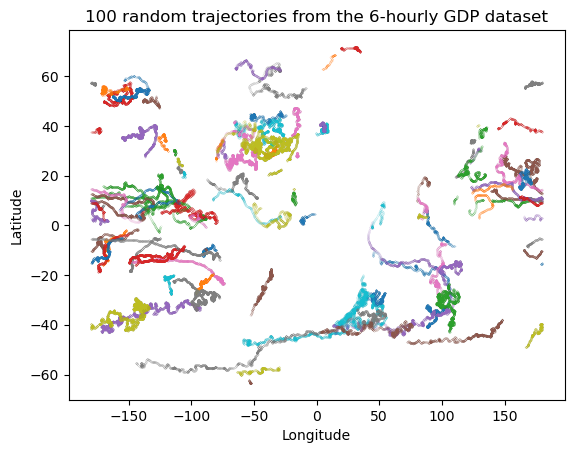

In [23]:
ids = np.repeat(ds.id, ds.rowsize).values

for drifter_id in drifter_ids:
    this_drifter = ids == drifter_id
    plt.plot(
        ds.lon[this_drifter], ds.lat[this_drifter], linestyle="", marker=".", ms=0.1
    )
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("100 random trajectories from the 6-hourly GDP dataset")

You may find that the method above is relatively slow to plot for a large number of trajectories. Alternatively, we can use `rowsize_to_index` from the `clouddrift.ragged` module, which returns an array that indexes the beginning of each trajectory in the ragged arrays (with index `0` for the first trajectory).

In [24]:
from clouddrift.ragged import rowsize_to_index

Text(0.5, 1.0, '100 random trajectories from the 6-hourly GDP dataset')

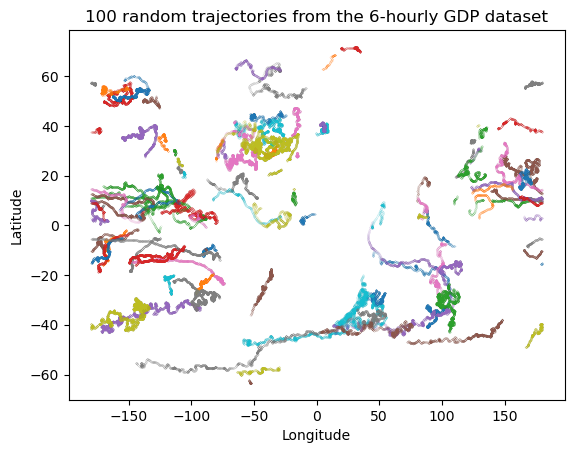

In [25]:
traj_idx = rowsize_to_index(ds.rowsize)

for j in range(len(drifter_ids)):
    plt.plot(
        ds.lon[slice(traj_idx[j], traj_idx[j + 1])],
        ds.lat[slice(traj_idx[j], traj_idx[j + 1])],
        linestyle="",
        marker=".",
        ms=0.1,
    )
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("100 random trajectories from the 6-hourly GDP dataset")

### Awkward Array

In [26]:
ds = ra.to_awkward()

With an awkward array, there is no need to define an index variable as for an xarray Dataset:

Text(0.5, 1.0, '100 random trajectories from a GDP dataset')

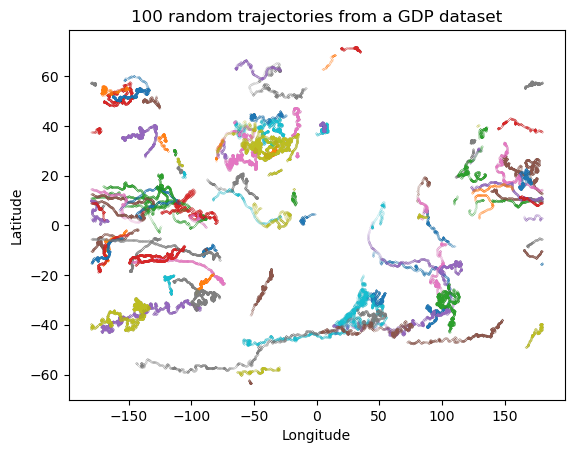

In [27]:
for n in range(len(drifter_ids)):
    plt.plot(ds.obs["lon"][n], ds.obs["lat"][n], linestyle="", marker=".", ms=0.1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("100 random trajectories from a GDP dataset")